In [1]:
# The code was removed by Watson Studio for sharing.

# Analysing Chinese Restaurants in New york

In [2]:
import pandas as pd    #for dataframe
import numpy as np    
import requests    
from bs4 import BeautifulSoup   #to get data from the  webpage
import geopy                 #geo location data
import os
import folium               #library map rendring
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import geopy.geocoders
from geopy.geocoders import Nominatim
print('Libraries Imported')

Libraries Imported


In [3]:
# function to get the geo location of a particular place
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer",scheme='http')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude,longitude]

In [4]:
print(geo_location('New York'))

[40.7127281, -74.0060152]


In [5]:
# function to get top 100 venus with in a radius of 1000 meters
def get_top_100_venues(lat,long):
    radius = 1000
    limit = 100
    version='20180605'
    client_id = '2U2J4FHBRBMFYBU1Q4MWRYLJ42JDJTPLCKJNUN0WQWKKBILK' # Foursquare ID
    client_secret =  '1WX354OPR2I2WDEKE2CFYOQCOAVSEXNU0QQC1CCHLD1W0GYZ'  #secret 
    #client_id = 'AWXVGMR5NECFMBZH0EUDAVMVTRWYGDKFJKIUCPLM4WGNT1ES' # Foursquare ID
    #client_secret =  '5X0AJCOOJSU4DAHXRSEP0404UV4NYGTYM3H0W3CU0WKMP4YU'  #secret 
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        client_id, 
        client_secret, 
        lat, 
        long, 
        version, 
        radius, 
        limit)
    result = requests.get(url).json()
    try:
        venues = result["response"]['groups'][0]['items']
        venue_data = []
        for row in venues:
            try:
                venue_id = row['venue']['id']
                venue_name = row['venue']['name']
                if row['venue']['categories'] != []:
                    venue_category = row['venue']['categories'][0]['name']
                venue_data.append([venue_id, venue_name, venue_category])
                continue
            except KeyError:
                pass
        column_name = ['ID', 'Name', 'Category']
        df = pd.DataFrame(venue_data, columns=column_name)
        return df
    except KeyError:
        print('No Data for', lat,',', long)
        pass

In [6]:
# get detail of a venue
def get_venue_details(venue_id):
    client_id = '2U2J4FHBRBMFYBU1Q4MWRYLJ42JDJTPLCKJNUN0WQWKKBILK' # Foursquare ID
    client_secret =  '1WX354OPR2I2WDEKE2CFYOQCOAVSEXNU0QQC1CCHLD1W0GYZ'  #secret 
    #client_id = 'AWXVGMR5NECFMBZH0EUDAVMVTRWYGDKFJKIUCPLM4WGNT1ES' # Foursquare ID
    #client_secret =  '5X0AJCOOJSU4DAHXRSEP0404UV4NYGTYM3H0W3CU0WKMP4YU'  #secret 
    version='20180605'
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, client_id, client_secret, version)
    result = requests.get(url).json()
    venue_details=[]
    try:
        venue=result['response']['venue']
        venue_id = venue['id']
        venue_name = venue['name']
        venue_likes = venue['likes']['count']
        venue_rating = venue['rating']
        venue_tips = venue['tips']['count']
        venue_details.append([venue_id, venue_name, venue_likes, venue_rating, venue_tips])
    except KeyError:
        pass
    column_name = ['ID', 'Name', 'Likes', 'Rating', 'Tips']
    #column_name = ['ID', 'Name', 'Likes', 'Tips']
    df = pd.DataFrame(venue_details, columns=column_name)
    return df

In [7]:
#method to get new york data
def get_ny_data():
    url='https://cocl.us/new_york_Dataset'
    resp = requests.get(url).json()
    #get all features
    features = resp['features']
    
    #new frame
    columns_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
    ny_data = pd.DataFrame(columns=columns_names)
    
    for data in features:
        borough = data['properties']['borough']
        neigh_name = data['properties']['name']
        
        neigh_laton = data['geometry']['coordinates']
        lat = neigh_laton[1]
        lon = neigh_laton[0]
        ny_data = ny_data.append({ 'Borough' : borough,
                                 'Neighborhood' : neigh_name,
                                 'Latitude' : lat,
                                  'Longitude' : lon
                                 }, ignore_index = True)
    return ny_data

In [8]:
# get new york data
ny_data=get_ny_data()

In [9]:
ny_data.shape

(306, 4)

In [10]:
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [11]:
#get no of unique Borough
ny_data.Borough.unique()

array(['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island'],
      dtype=object)

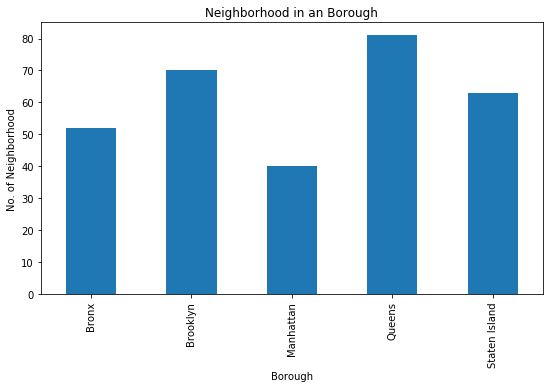

In [12]:
# their are 5 borough in NY lets plot neighbourhood data for each of them. 
plt.figure(figsize=(9,5))
plt.title('Neighborhood in an Borough')
plt.xlabel('Borough')
plt.ylabel('No. of Neighborhood')
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.show()

In [13]:
    # read file from storage.
# Since call to foursquare are limited we save the data for later use.
my_file = project.get_file('chinese_restaurant_Details.csv')
my_file.seek(0)

chinese_rest_ny = pd.read_csv(my_file)
#chinese_rest_ny_csv=pd.read_csv('chinese_restaurant_Details.csv')
chinese_rest_ny.shape

(914, 4)

In [14]:
# Lets get the top 100 venues in each place in Ny and find chinese restaurant in them
# prepare neighborhood list that contain chinese resturants

# first check if we have downloaded the data from storage. 
if chinese_rest_ny.empty == True:    
    #no data exists in the storage download the data. 
    columns_names = ['Borough', 'Neighborhood', 'ID', 'Name']
    chinese_rest_ny =pd.DataFrame(columns=columns_names)
    count=1

    for row in ny_data.values:

        borough, neigh_name, lat, long = row
        venues = get_top_100_venues(lat, long)

        ind_rest= venues[venues['Category']=='Chinese Restaurant']

        print('(',count,'/',len(ny_data),')', 'Chinese Restaurant in ' +neigh_name+ ','+borough+':'+str(len(ind_rest)))

        for restaurant_detail in ind_rest.values:
            id,name,category=restaurant_detail
            chinese_rest_ny = chinese_rest_ny.append({ 'Borough' : borough,
                                              'Neighborhood' : neigh_name,
                                              'ID' : id,
                                              'Name' : name
                                             }, ignore_index = True)
        count+=1
else:
    print("Data downloaded from the Local Server")

Data downloaded from the Local Server


In [15]:
chinese_rest_ny.shape

(914, 4)

In [16]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Co-op City,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant
2,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
3,Bronx,Eastchester,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant
4,Bronx,Fieldston,4cc4d337be40a35d390b814c,Lee's Chinese Kitchen


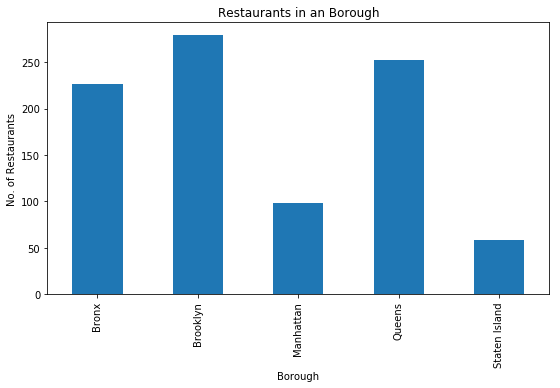

In [17]:
# lets plot restaurants as per the Borough 
plt.figure(figsize=(9,5))
plt.title('Restaurants in an Borough')
plt.xlabel('Borough')
plt.ylabel('No. of Restaurants')
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.show()

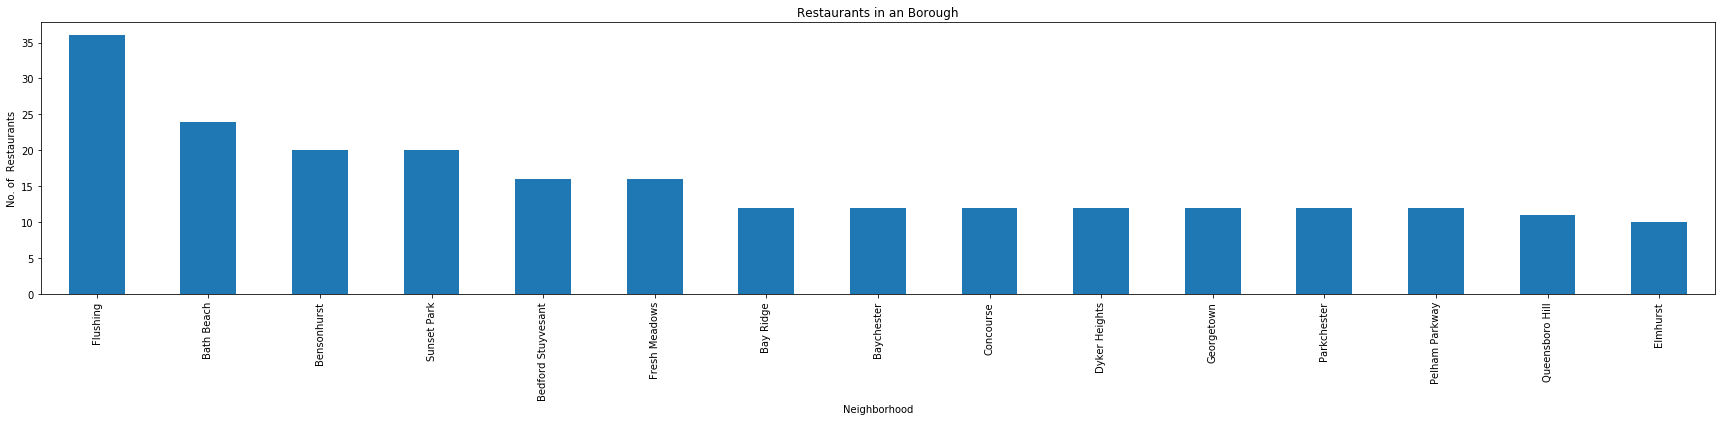

In [18]:
# since max number of restaurants neightbourhood
# lets plot top 15 Borough with max restaurants as per the  
plt.figure(figsize=(30,5))
plt.title('Restaurants in an Borough')
plt.xlabel('Neighborhood')
plt.ylabel('No. of  Restaurants')
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(15).plot(kind='bar')
plt.show()

In [19]:
#save file to library for later use
project.save_data(file_name = "chinese_restaurant_Details.csv",data = chinese_rest_ny.to_csv(index=False), overwrite=True)

{'file_name': 'chinese_restaurant_Details.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'dataanalysiscapstone-donotdelete-pr-mzve2vugobkxth',
 'asset_id': '39570cee-8f8a-4aea-9bb2-f713c176d6be'}

In [20]:
# lets get rating for each restaurant

### get file from the saved values
# read file from storage.
# Since call to foursquare are limited we save the data for later use.
my_file = project.get_file('chinese_restaurant_Rating.csv')
my_file.seek(0)

chinese_rest_rating_csv = pd.read_csv(my_file)

chinese_rest_rating_csv.shape
chinese_rest_rating = chinese_rest_rating_csv

if chinese_rest_rating.empty == True:  

    # prepare neighborhood list that contain resturants
    columns_names = ['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
    chinese_rest_rating=pd.DataFrame(columns=columns_names)
    count = 1 

    for row in chinese_rest_ny.values:
        Borough, Neighborhood, id, name = row
        try:
            venue_details=get_venue_details(id)
            print(venue_details)
            id, name, likes, rating, tips = venue_details.iloc[0]
        except IndexError:
            print('No data Availabe for ID', id)
            id, name, likes, rating, tips = [0]*5

        print('(',count,'/',len(chinese_rest_ny),')','processed')        
        chinese_rest_rating = chinese_rest_rating.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips
                                                   }, ignore_index=True)
        count+=1
else:
    print("Data loaded from Local server")

Data loaded from Local server


In [21]:
chinese_rest_rating.shape

(316, 7)

In [22]:
chinese_rest_rating_edit = chinese_rest_rating

In [23]:
chinese_rest_rating = chinese_rest_rating[chinese_rest_rating.ID != 0]
chinese_rest_rating.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,4.9,10
1,Bronx,Riverdale,4b2286f1f964a5205a4824e3,Hunan Balcony,13,6.5,7
2,Bronx,Kingsbridge,4b2286f1f964a5205a4824e3,Hunan Balcony,13,6.5,7
3,Bronx,Norwood,4e2e08021838f1c552b6b8eb,Choi Yuan - Chinese Restaurant,6,6.7,7
4,Bronx,Norwood,4e4d0387bd413c4cc66dfd72,Hung Hing Chinese Restaurant,5,6.4,2


In [24]:
chinese_rest_rating.shape

(316, 7)

In [25]:
# lets save data to read it later. 
#save file to library for later use
project.save_data(file_name = "chinese_restaurant_Rating.csv",data = chinese_rest_rating.to_csv(index=False), overwrite=True)

{'file_name': 'chinese_restaurant_Rating.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'dataanalysiscapstone-donotdelete-pr-mzve2vugobkxth',
 'asset_id': '97a65a4c-afd4-4d79-a749-f5ba2da1dfa5'}

In [26]:
chinese_rest_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 0 to 315
Data columns (total 7 columns):
Borough         316 non-null object
Neighborhood    316 non-null object
ID              316 non-null object
Name            316 non-null object
Likes           316 non-null int64
Rating          316 non-null float64
Tips            316 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 19.8+ KB


In [27]:
chinese_rest_rating['Likes'] = chinese_rest_rating['Likes'].astype('float64')

In [28]:
chinese_rest_rating['Tips'] = chinese_rest_rating['Tips'].astype('float64')

In [29]:
chinese_rest_rating['Rating'] = chinese_rest_rating['Rating'].astype('float64')

In [30]:
chinese_rest_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316 entries, 0 to 315
Data columns (total 7 columns):
Borough         316 non-null object
Neighborhood    316 non-null object
ID              316 non-null object
Name            316 non-null object
Likes           316 non-null float64
Rating          316 non-null float64
Tips            316 non-null float64
dtypes: float64(3), object(4)
memory usage: 19.8+ KB


In [31]:
# lets visualise neighborhood data with the maximum average rating of restaurants

In [32]:
#'Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips'
neighborhood_rating = chinese_rest_rating.groupby('Neighborhood', as_index=False).mean()[['Neighborhood', 'Rating']]
neighborhood_rating.columns = ['Neighborhood', 'Average Rating']
neighborhood_rating

,Neighborhood,Average Rating
0,Bath Beach,6.725000
1,Bay Ridge,7.633333
2,Baychester,6.800000
3,Bedford Park,6.550000
4,Bedford Stuyvesant,7.025000
5,Belmont,7.400000
6,Bensonhurst,7.100000
7,Boerum Hill,8.750000
8,Briarwood,6.900000
9,Cambria Heights,5.700000


In [33]:
neighborhood_rating.sort_values(['Average Rating'], ascending=False).head(5)

,Neighborhood,Average Rating
11,Chelsea,9.20
50,Long Island City,9.10
51,Lower East Side,9.00
38,Gramercy,8.95
83,West Village,8.95


In [34]:
# lets visualise neighborhood data with the maximum average rating of restaurants

In [35]:
#'Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips'
Borough_rating = chinese_rest_rating.groupby('Borough', as_index=False).mean()[['Borough', 'Rating']]
Borough_rating.columns=['Borough', 'Average Rating']

In [36]:
Borough_rating.sort_values(['Average Rating'], ascending=False).head(5)

,Borough,Average Rating
2,Manhattan,8.114286
1,Brooklyn,7.416779
3,Queens,7.353333
0,Bronx,6.694828


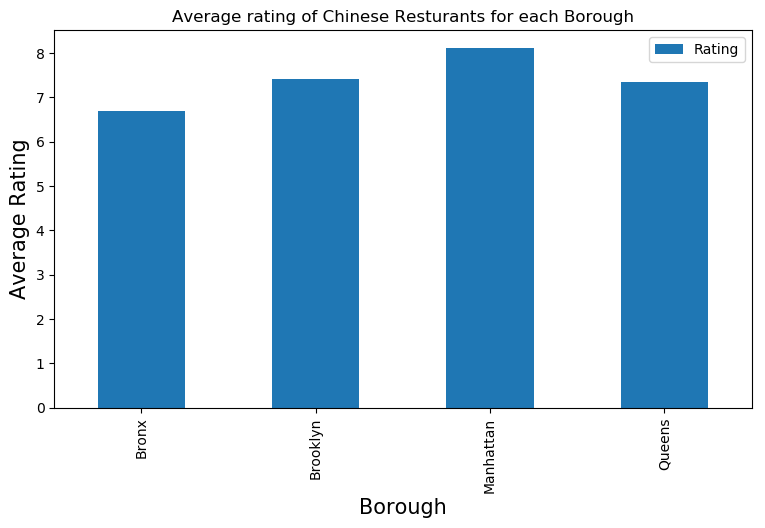

In [37]:
#let visualise
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_rating.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [38]:
neighborhood_rating_ab_8 = neighborhood_rating[neighborhood_rating['Average Rating']>8.7]
neighborhood_rating_ab_8

,Neighborhood,Average Rating
7,Boerum Hill,8.75
11,Chelsea,9.20
12,Chinatown,8.80
22,Downtown,8.75
26,East Village,8.95
38,Gramercy,8.95
48,Little Italy,8.90
50,Long Island City,9.10
51,Lower East Side,9.00
54,Marine Park,8.80


In [49]:
neighborhood_rating_ab_8.sort_values(['Average Rating'], ascending=False)

,Neighborhood,Average Rating
11,Chelsea,9.20
50,Long Island City,9.10
51,Lower East Side,9.00
38,Gramercy,8.95
83,West Village,8.95
26,East Village,8.95
48,Little Italy,8.90
58,Murray Hill,8.90
60,North Side,8.90
75,South Side,8.90


In [39]:
neighborhood_stats = pd.merge(ny_data, neighborhood_rating_ab_8, on='Neighborhood')

In [40]:
ny_neighborhood_stats= neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [41]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Marine Park,40.609748,-73.931344,8.80
1,Brooklyn,Downtown,40.690844,-73.983463,8.75
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.75
3,Brooklyn,North Side,40.714823,-73.958809,8.90
4,Brooklyn,South Side,40.710861,-73.958001,8.90
5,Manhattan,Chinatown,40.715618,-73.994279,8.80
6,Manhattan,Upper West Side,40.787658,-73.977059,8.90
7,Manhattan,Midtown,40.754691,-73.981669,8.85
8,Manhattan,Murray Hill,40.748303,-73.978332,8.90
9,Queens,Murray Hill,40.764126,-73.812763,8.90


In [42]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [43]:

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [44]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [45]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)